In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Functions
---


In [ ]:
#Removes column of class labels from dataframe and saves into new array
def features_labels_split(data, label_column):
    features = data.copy()
    columns_titles = list(data.columns)
    features = features.reindex(columns=columns_titles)
    labels = features.pop(label_column)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels


#Plots training/validation accuracy and loss. Can optionally print the numerical values.
def plot_train_val(model_history, metrics=True):
    train_acc = np.array(model_history.history["accuracy"])
    train_loss = np.array(model_history.history["loss"])

    val_loss = np.array(model_history.history["val_loss"])
    val_acc = np.array(model_history.history["val_accuracy"])

    epochs = np.arange(train_loss.shape[0])
    plt.figure(figsize=(10,5)) 
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label = "Training")
    plt.plot(epochs, val_loss, label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5)) 
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label = "Training")
    plt.plot(epochs, val_acc, label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.show()

    train_score = [train_acc[-1], train_loss[-1]]
    val_score = [val_acc[-1], val_loss[-1]]

    if metrics == True:
        print(f"\nTraining accuracy: {round(train_score[0], 5) * 100}%")
        print(f"Training loss: {round(train_score[1], 4)}")
        print(f"\nValidation accuracy: {round(val_score[0], 5) * 100}%")
        print(f"Validation loss: {round(val_score[1], 4)}")

## Load Data

---

In [ ]:
#Load balanced dataset
data =  pd.read_csv(f'/content/drive/MyDrive/cybersecurity project/ML Model/Datasets/data/UNSW-NB15_balanced.csv', delimiter = ",")
data

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,Label
0,45697,25,tcp,FIN,1.583880,37886,3484,31,29,19,8,smtp,1.878173e+05,1.719827e+04,54,44,255,255,4272429243,2148125176,0
1,46439,47450,tcp,FIN,0.024603,3302,37798,31,29,7,21,-,1.053855e+06,1.207137e+07,54,56,255,255,1684438380,1684722280,0
2,7588,43374,tcp,FIN,0.038918,2334,16438,31,29,7,12,-,4.666221e+05,3.290200e+06,36,38,255,255,3751515925,3798669427,0
3,26802,53,udp,CON,0.001043,146,178,31,29,0,0,dns,5.599233e+05,6.826462e+05,2,2,0,0,0,0,0
4,61139,53,udp,CON,0.001099,146,178,31,29,0,0,dns,5.313922e+05,6.478617e+05,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,35369,80,tcp,FIN,0.289723,864,1390,254,252,2,2,-,2.148259e+04,3.360451e+04,10,8,255,255,3681792013,1705323518,1
2744,24841,25,tcp,FIN,1.012112,806,1096,254,252,5,4,-,5.920293e+03,8.046540e+03,14,14,255,255,4198805689,2462692123,1
2745,27333,143,tcp,FIN,1.206070,1010,4962,62,252,6,8,-,6.327991e+03,3.126850e+04,18,20,255,255,2909098937,254268601,1
2746,25474,88,udp,CON,0.169691,2132,1512,254,60,0,0,-,7.538409e+04,3.564125e+04,4,2,0,0,0,0,1


In [ ]:
#one hot encoding categorical columns: state, proto
proto = pd.get_dummies(data["proto"],prefix='proto')
service = pd.get_dummies(data["service"],prefix='service')
state = pd.get_dummies(data["state"],prefix='state')

data = data.merge(proto, how='outer', left_index=True, right_index=True)
data = data.merge(service, how='outer', left_index=True, right_index=True)
data = data.merge(state, how='outer', left_index=True, right_index=True)

In [ ]:
data

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,Label,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,...,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_smtp,service_snmp,service_ssh,service_ssl,state_CLO,state_CON,state_FIN,state_INT,state_REQ
0,45697,25,tcp,FIN,1.583880,37886,3484,31,29,19,8,smtp,1.878173e+05,1.719827e+04,54,44,255,255,4272429243,2148125176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,46439,47450,tcp,FIN,0.024603,3302,37798,31,29,7,21,-,1.053855e+06,1.207137e+07,54,56,255,255,1684438380,1684722280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,7588,43374,tcp,FIN,0.038918,2334,16438,31,29,7,12,-,4.666221e+05,3.290200e+06,36,38,255,255,3751515925,3798669427,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,26802,53,udp,CON,0.001043,146,178,31,29,0,0,dns,5.599233e+05,6.826462e+05,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,61139,53,udp,CON,0.001099,146,178,31,29,0,0,dns,5.313922e+05,6.478617e+05,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,35369,80,tcp,FIN,0.289723,864,1390,254,252,2,2,-,2.148259e+04,3.360451e+04,10,8,255,255,3681792013,1705323518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2744,24841,25,tcp,FIN,1.012112,806,1096,254,252,5,4,-,5.920293e+03,8.046540e+03,14,14,255,255,4198805689,2462692123,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2745,27333,143,tcp,FIN,1.206070,1010,4962,62,252,6,8,-,6.327991e+03,3.126850e+04,18,20,255,255,2909098937,254268601,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2746,25474,88,udp,CON,0.169691,2132,1512,254,60,0,0,-,7.538409e+04,3.564125e+04,4,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
data = data.drop(columns=['proto', 'state', 'service'])
data

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,Label,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,...,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_smtp,service_snmp,service_ssh,service_ssl,state_CLO,state_CON,state_FIN,state_INT,state_REQ
0,45697,25,1.583880,37886,3484,31,29,19,8,1.878173e+05,1.719827e+04,54,44,255,255,4272429243,2148125176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,46439,47450,0.024603,3302,37798,31,29,7,21,1.053855e+06,1.207137e+07,54,56,255,255,1684438380,1684722280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,7588,43374,0.038918,2334,16438,31,29,7,12,4.666221e+05,3.290200e+06,36,38,255,255,3751515925,3798669427,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,26802,53,0.001043,146,178,31,29,0,0,5.599233e+05,6.826462e+05,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,61139,53,0.001099,146,178,31,29,0,0,5.313922e+05,6.478617e+05,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,35369,80,0.289723,864,1390,254,252,2,2,2.148259e+04,3.360451e+04,10,8,255,255,3681792013,1705323518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2744,24841,25,1.012112,806,1096,254,252,5,4,5.920293e+03,8.046540e+03,14,14,255,255,4198805689,2462692123,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2745,27333,143,1.206070,1010,4962,62,252,6,8,6.327991e+03,3.126850e+04,18,20,255,255,2909098937,254268601,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2746,25474,88,0.169691,2132,1512,254,60,0,0,7.538409e+04,3.564125e+04,4,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
data.duplicated().value_counts()

False    2747
True        1
dtype: int64

In [ ]:
#Separate data from the labels in the pandas dataframe into their own numpy arrays
x, y = features_labels_split(data, 'Label')

print(x.shape)
print(y.shape)

(2748, 164)
(2748,)


In [ ]:
#Separate data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)

x_train shape:  (1923, 164)
y_train shape:  (1923,)
x_test shape:  (412, 164)
y_test shape:  (412,)
x_val shape:  (413, 164)
y_val shape:  (413,)


In [ ]:
#Label one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print('y_train one-hot shape: ', y_train.shape)
print('y_val one-hot shape: ', y_val.shape)
print('y_test one-hot shape: ', y_test.shape)

y_train one-hot shape:  (1923, 2)
y_val one-hot shape:  (413, 2)
y_test one-hot shape:  (412, 2)


In [ ]:
#Normalize Data
scaler = MinMaxScaler() 

x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val) 
x_test = scaler.transform(x_test)

In [ ]:
y_test.shape

(412, 2)

## ANN Model


*'DEEP-INTRUSION DETECTION SYSTEM WITH ENHANCED UNSW-NB15 DATASET BASED ON DEEP LEARNING TECHNIQUES', A.M. ALEESA, MOHAMMED YOUNIS, AHMED A. MOHAMMED, NAN M. SAHAR*


---

In [ ]:
#Define
model = Sequential()

model.add(Dense(input_dim=x_train.shape[1], units=1, activation='relu')) #input & hidden layer 1
model.add(Dense(units=2, activation='softmax')) #output/prediction layer

model.summary() #display model architecture information

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 165       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile
model.compile(loss="binary_crossentropy",  #they did not specify loss function, assume binary cross entropy
        optimizer=Adam(learning_rate=0.005), #they did not specify learning rate, placeholder value for now
        metrics=["accuracy"])

In [ ]:

#Fit
start = time()
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    #batch_size=50,
    verbose=1 #do not display output as model is training
)


print(f'Complete. \nModel trained in {round(time()-start, 2)} sec')

Epoch 1/50
61/61 [==============================] - 1s 4ms/step - loss: 0.5794 - accuracy: 0.7301 - val_loss: 0.4464 - val_accuracy: 0.7143
Epoch 2/50
61/61 [==============================] - 0s 2ms/step - loss: 0.3792 - accuracy: 0.7301 - val_loss: 0.3294 - val_accuracy: 0.7143
Epoch 3/50
61/61 [==============================] - 0s 2ms/step - loss: 0.2946 - accuracy: 0.7769 - val_loss: 0.2677 - val_accuracy: 0.9370
Epoch 4/50
61/61 [==============================] - 0s 2ms/step - loss: 0.2399 - accuracy: 0.9397 - val_loss: 0.2209 - val_accuracy: 0.9516
Epoch 5/50
61/61 [==============================] - 0s 2ms/step - loss: 0.1958 - accuracy: 0.9719 - val_loss: 0.1815 - val_accuracy: 0.9831
Epoch 6/50
61/61 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9860 - val_loss: 0.1533 - val_accuracy: 0.9879
Epoch 7/50
61/61 [==============================] - 0s 2ms/step - loss: 0.1337 - accuracy: 0.9875 - val_loss: 0.1273 - val_accuracy: 0.9879
Epoch 8/50
61/61 [==

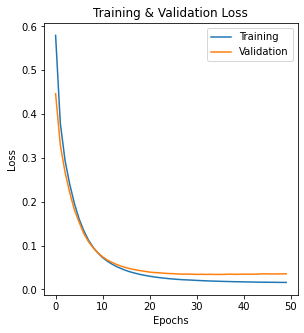

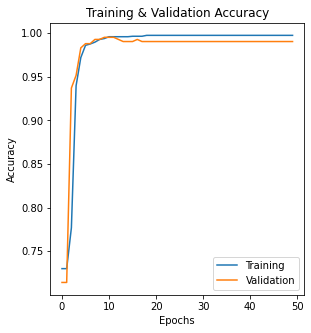


Training accuracy: 99.74%
Training loss: 0.016

Validation accuracy: 99.031%
Validation loss: 0.0358


In [ ]:
plot_train_val(history)

## Evaluation Metrics
---

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1) 
y_true = np.argmax(y_test, axis=-1) 

acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision  = precision_score(y_true, y_pred, average='weighted')
f1  = f1_score(y_true, y_pred, average='weighted')

print('Accuracy: ', acc)
print('Precision: ', recall)
print('Recall: ', precision)
print('F1-score: ', f1)
# print('AUC: ', auc)

# y_test_one_hot = to_categorical(y_test) #roc_auc_score function needs data in one-hot encoding format for multiclass classification
# auc  = roc_auc_score(y_test_one_hot, trained_model.predict_proba(x_test), average='weighted', multi_class='ovr')

Accuracy:  0.9927184466019418
Precision:  0.9927184466019418
Recall:  0.9929100664282065
F1-score:  0.9927487560173104
